# **MetaMask Performance Dashboard **

In [ ]:
### Authenticate with Google Cloud Platform to run BigQuery queries
from google.colab import auth
auth.authenticate_user()

# **Tech Used**


1.   Dataset: bigquery-public-data.crypto_ethereum (Dataset contains all Ethreum Blockchain Transactions which is updated in Realtime)
2.   Bigquery & SQL is used to query the Dataset and derive various KPA's.
3.   Plotly Library is used for Data Visualization
4.   Streamlit is used to construct the Web-App Dashboard


# **Tables used:**
 

1.    ***Transactions table*** lists all transactions initiated by external owned accounts.(eg: Account on Metamask), irrespective of who initiated the transaction — the receiver or the sender.
2.   ***Traces table*** (Internal Transactions) lists all transactions initiated by internal accounts (i.e smart contract). 
  -eg: Lets Assume a Externally owned account 'A' invokes a Smart-Contract 'X' which inturn invokes a function of Smart-Contract 'Y'
  -Here the Transaction 'A'----> 'X' gets listed in the Transaction Table as  'A' is a external Account, while
  -Transaction 'X'----> 'Y' gets listed in the Traces Table as 'X' is a smart contract

3. ***Token Transfer*** Table lists all ERC-20 token transfers.

# **Addresses Used**:



1.  Swap Router,Metamask: 0x881d40237659c251811cec9c364ef91dc08d300c 
2.  Smart Contract, Metamask: 0x74de5d4fcbf63e00296fd95d33236b9794016631
3.  Fees, Metamask: 0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb  
4.  DS Proxy, Metamask: 0xf326e4de8f66a0bdc0970b79e0924e33c79f1915





--------------------------------------------------------------------------------
# **Dashboard is being divided into 4 Sections:**
# Section 1: Overview


1.   Total Wallet Balance in USD
2.   Individual Wallet Balance of

*   Metamask-Fees
*   DS-Proxy-Multisig


3.   Daily, Weekly, Monthly Unique Users
4.   Daily, Weekly, Monthly Trading Volume


5.   Top 10 Traders by Volume
6.   top 10 Traders by Swaps


# Section 2: Swap Metrics
1.   Daily Volume & Cumulative Volume
2.   Daily Revenue & Cumulative Revenue
3.   Daily Swaps & Cumulative Swaps
4.   New Trader's v/s Returning Trader's

# Section 3: Dex Analogy
1.   Top 5 DEX Traded Volume Comparison
2.   Top 5 DEX Users Comparison

# Section 4: Quarterly Performance
1.   QoQ Revenue
2.   QoQ Active Users
3.   QoQ Volumes
4.   QoQ Swaps
--------------------------------------------------------------------------------



## Section 1: Overview


1.1.   **Total Wallet Balance in USD**


*   -aggregates sum of balances in Metamask-Fees and DS-Proxy Wallet by querying 'crypto_ethereum.balances' table
*   Display metric a Gauge chart.



In [ ]:

#Metamask total Balance
%%bigquery --project nansen-352205 df_Wallet_Balance
SELECT
  ROUND(SUM((CAST(eth_balance AS FLOAT64)/1e18)*1750),0) AS Balance_in_USD,ROUND(SUM(CAST(eth_balance AS FLOAT64)/1e18),0) AS Balance_in_ETH
FROM
  `bigquery-public-data.crypto_ethereum.balances`
WHERE
  address IN( '0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb',
    '0xf326e4de8f66a0bdc0970b79e0924e33c79f1915');



In [ ]:
df_Wallet_Balance

,Balance_in_USD,Balance_in_ETH
0,29820125.0,17040.0


In [ ]:
figx = go.Figure(go.Indicator(
          domain = {'x': [0, 1], 'y': [0, 1]},
          value = 45641389,
          mode = "gauge+number+delta",
          title = {'text': "Account Value"},
          delta = {'reference': 45541389}))
figx['layout'].update( width = 800,height = 400)
figx.show()

1.2.   **Individual Wallet Balance of**



1.   Metamask-Fees ('0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb')
2.   DS-Proxy ('0xf326e4de8f66a0bdc0970b79e0924e33c79f1915')



*   Get individual wallet balance of Metamask-Fees and DS-Proxy Wallet by querying 'crypto_ethereum.balances' table
*   Display metric a Pie chart.

In [ ]:
#Metamask individual wallet Balance

%%bigquery --project nansen-352205 df_Solo_Wallet_Balances
SELECT
  CASE
    WHEN address ='0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb' THEN "Metamask_Fees"
    WHEN address ='0xf326e4de8f66a0bdc0970b79e0924e33c79f1915' THEN "DS_Proxy_Multisig"
END
  AS Wallet,
  address AS Wallet_Address,
  ROUND(SUM((CAST(eth_balance AS FLOAT64)/1e18)*1750),0) AS Balance_in_USD,
  ROUND(SUM(CAST(eth_balance AS FLOAT64)/1e18),0) AS Balance_in_ETH
FROM
  `bigquery-public-data.crypto_ethereum.balances`
WHERE
  address IN( '0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb',
    '0xf326e4de8f66a0bdc0970b79e0924e33c79f1915')
GROUP BY
  address;

In [ ]:
from google.colab import files

df_Solo_Wallet_Balances.to_csv('df_Solo_Wallet_Balances.csv', encoding = 'utf-8-sig',index=False) 
df_Solo_Wallet_Balances

,Wallet,Wallet_Address,Balance_in_USD,Balance_in_ETH
0,DS_Proxy_Multisig,0xf326e4de8f66a0bdc0970b79e0924e33c79f1915,29671233.0,16955.0
1,Metamask_Fees,0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb,148892.0,85.0


In [ ]:
#Metamask individual wallet Balance

import plotly.express as px

fig = px.pie(df_Solo_Wallet_Balances, values='Balance_in_USD', names='Wallet', title='Wallet Balance',hole=.3,width = 1000,height = 500)
fig.show()

1.3.   **Daily, Weekly, Monthly Unique Users**

*   Get Daily, Weekly, Monthly Unique Users by querying 'crypto_ethereum.transactions' table to get Distinct(from_address's) calling Metamask_Swap_Router in order to swap.
*   Display metric a Gauge chart.

In [ ]:
#UNIQUE_USERS_24HRS
%%bigquery --project nansen-352205 df_UNIQUE_USERS_24HRS
SELECT
  COUNT(DISTINCT(from_address))AS UNIQUE_USERS_24HRS
FROM
  `bigquery-public-data.crypto_ethereum.transactions`
WHERE
  DATE(block_timestamp) = "2022-06-01"
  AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c');

In [ ]:
df_UNIQUE_USERS_24HRS

,UNIQUE_USERS_24HRS
0,4344


In [ ]:
figx = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 4344,
            mode = "gauge+number+delta",
            title = {'text': "Users"},
            delta = {'reference': 4300}))
figx['layout'].update( width = 800,height = 400)
figx.show()

In [ ]:
#UNIQUE_USERS_7days
%%bigquery --project nansen-352205 df_UNIQUE_USERS_7days
SELECT
  SUM(UNIQUE_USERS_7days) as UNIQUE_USERS_7days
FROM (
  SELECT
    DATE(block_timestamp) AS DATE_,
    COUNT(DISTINCT(from_address))AS UNIQUE_USERS_7days
  FROM
    `bigquery-public-data.crypto_ethereum.transactions`
  WHERE
    DATE(block_timestamp) BETWEEN "2022-05-25"
    AND "2022-05-31"
    AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
  GROUP BY
    DATE(block_timestamp))


In [ ]:
df_UNIQUE_USERS_7days

,UNIQUE_USERS_7days
0,34567


In [ ]:
figy = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 34567,
            mode = "gauge+number+delta",
            title = {'text': "Users"},
            delta = {'reference': 38000}))
figy['layout'].update( width = 800,height = 400)
figy.show()

In [ ]:
#UNIQUE_USERS_1month
%%bigquery --project nansen-352205 df_UNIQUE_USERS_1month
SELECT
  SUM(UNIQUE_USERS_1month) as UNIQUE_USERS_1month
FROM (
  SELECT
    DATE(block_timestamp) AS DATE_,
    COUNT(DISTINCT(from_address))AS UNIQUE_USERS_1month
  FROM
    `bigquery-public-data.crypto_ethereum.transactions`
  WHERE
    DATE(block_timestamp) BETWEEN "2022-05-01"
    AND "2022-05-31"
    AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
  GROUP BY
    DATE(block_timestamp))

In [ ]:
df_UNIQUE_USERS_1month

,UNIQUE_USERS_1month
0,192681


In [ ]:
figz = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 192681,
            mode = "gauge+number+delta",
            title = {'text': "Users"},
            delta = {'reference': 213700}))
figz['layout'].update( width = 800,height = 400)
figz.show()

1.4.   **Daily, Weekly, Monthly Trading Volume**

*   Get Daily, Weekly, Monthly Trading Volume by querying 'crypto_ethereum.transactions' table to get sum(value) transferred to Metamask_Swap_Router in order to swap.
*   Display metric a Gauge chart.

In [ ]:
#Volume_24HRS
%%bigquery --project nansen-352205 df_Volume_24HRS
SELECT
  ROUND(SUM((CAST(value AS FLOAT64)/1e18)*1750),0) AS Volume_24HR_USD,
  ROUND(SUM(CAST(value AS FLOAT64)/1e18),0) AS Volume_24HR_ETH
FROM
  `bigquery-public-data.crypto_ethereum.transactions`
WHERE
  DATE(block_timestamp) = "2022-06-01"
  AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c');

In [ ]:
df_Volume_24HRS

,Volume_24HR_USD,Volume_24HR_ETH
0,7005963.0,4003.0


In [ ]:
figx = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 700563,
            mode = "gauge+number+delta",
            title = {'text': "Volume"},
            delta = {'reference': 600999}))
figx['layout'].update( width = 800,height = 400)
figx.show()

In [ ]:
#Volume_7days
%%bigquery --project nansen-352205 df_Volume_7days
SELECT
  SUM(Volume_7days_USD) as Volume_7days_USD,
  SUM(Volume_7days_ETH) as Volume_7days_ETH ,
  FROM (
    SELECT
      DATE(block_timestamp) AS DATE_,
      ROUND(SUM((CAST(value AS FLOAT64)/1e18)*1750),0) AS Volume_7days_USD,
      ROUND(SUM(CAST(value AS FLOAT64)/1e18),0) AS Volume_7days_ETH
    FROM
      `bigquery-public-data.crypto_ethereum.transactions`
    WHERE
      DATE(block_timestamp) BETWEEN "2022-05-25"
      AND "2022-05-31"
      AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
    GROUP BY
      DATE(block_timestamp))
  


In [ ]:
df_Volume_7days

,Volume_7days_USD,Volume_7days_ETH
0,51031218.0,29161.0


In [ ]:
figy = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 51031218,
            mode = "gauge+number+delta",
            title = {'text': "Volume"},
            delta = {'reference': 65040000}))
figy['layout'].update( width = 800,height = 400)
        
figy.show()

In [ ]:
#Volume_1month
%%bigquery --project nansen-352205 df_Volume_1month
SELECT
  SUM(Volume_1month_USD) as Volume_1month_USD,
  SUM(Volume_1month_ETH) as Volume_1month_ETH ,
  FROM (
    SELECT
      DATE(block_timestamp) AS DATE_,
      ROUND(SUM((CAST(value AS FLOAT64)/1e18)*1750),0) AS Volume_1month_USD,
      ROUND(SUM(CAST(value AS FLOAT64)/1e18),0) AS Volume_1month_ETH
    FROM
      `bigquery-public-data.crypto_ethereum.transactions`
    WHERE
      DATE(block_timestamp) BETWEEN "2022-05-01"
      AND "2022-05-31"
      AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
    GROUP BY
      DATE(block_timestamp))
  

In [ ]:

df_Volume_1month

,Volume_1month_USD,Volume_1month_ETH
0,291254083.0,166432.0


In [ ]:
figz = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 291254083,
            mode = "gauge+number+delta",
            title = {'text': "Volume"},
            delta = {'reference': 386264083}))
figz['layout'].update( width = 800,height = 400)
        
figz.show()

1.4.   ** Top 10 Traders by Volume**

*   Get Top 10 Traders by Volume by querying 'crypto_ethereum.transactions' table to get Top-10 (from_addresses) that were responsible for majority of the trading volume.  
*   Display metric a Pie Chart.

In [ ]:
# Top 10 Traders by Volume

%%bigquery --project nansen-352205 df_top10_traders_by_Volume
SELECT
  from_address,
  Traded_Volume,
FROM (
  SELECT
    from_address,
    ROUND(SUM((CAST(value AS FLOAT64)/1e18)*1750),0) AS Traded_Volume,
  FROM
    `bigquery-public-data.crypto_ethereum.transactions`
  WHERE
    DATE(block_timestamp) BETWEEN "2022-05-01"
    AND "2022-05-31"
    AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
  GROUP BY
    from_address)
ORDER BY
  Traded_Volume DESC
LIMIT
  10;

In [ ]:
df_top10_traders_by_Volume.to_csv('df_top10_traders_by_Volume.csv', encoding = 'utf-8-sig',index=False) 
df_top10_traders_by_Volume

,from_address,Traded_Volume
0,0x21c00b85af079a166c83dac8fcd9bf140cc1998a,4501700.0
1,0xdd8c7cac55376f93deedc265bbb7a736e2f48284,2191000.0
2,0xad685cbcc90b3fca20d10e175666dfbdce9edeaf,2100000.0
3,0xbff79922fcbf93f9c30abb22322b271460c6bebb,1962784.0
4,0x6a36628373bdc72b8589f23decefdb8556a512fc,1844605.0
5,0x642f049ffc37699553553404ee31a8a6ced14d75,1737750.0
6,0xd2595b3632cffd5a308eb10d868518380fdee768,1501325.0
7,0x8468c23cd54fb84fcc1dd06a98bd6e1ef58102f7,1298500.0
8,0x045100be931ff5bc553e609950e117ef5fb4cd9b,1190000.0
9,0x08d6499ae1bd25148c3c8ba62658225d37b2e55f,1137500.0


In [ ]:
figxx = px.pie(df_top10_traders_by_Volume, values='Traded_Volume', names='from_address',width = 1000,height = 500,title='Top-10 Traders by Volume')
figxx.show()

1.4.   ** top 10 Traders by Swaps**

*   Get Top 10 Traders by Swaps by querying 'crypto_ethereum.transactions' table to get Top-10 (from_addresses) that performed maximum number of swaps.  
*   Display metric a Pie Chart.

In [ ]:

# Top 10 Traders by Swaps

%%bigquery --project nansen-352205 df_top10_traders_by_Swaps
SELECT
  from_address,No_of_Swaps
FROM (
  SELECT
    DISTINCT t. from_address,COUNT(t.hash) as No_of_Swaps
  FROM
    `bigquery-public-data.crypto_ethereum.transactions` t
  WHERE
    DATE(block_timestamp) BETWEEN "2022-05-01"
    AND "2022-05-31"
    AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
  GROUP BY
    from_address)
ORDER BY
  No_of_Swaps DESC
LIMIT
  10;

In [ ]:
df_top10_traders_by_Swaps.to_csv('df_top10_traders_by_Swaps.csv', encoding = 'utf-8-sig',index=False) 
df_top10_traders_by_Swaps

,from_address,No_of_Swaps
0,0xd0a845b013db49008908d35cda1c0d85fcb00844,197
1,0xe853d53d9dd5b0266dda2b2475b638664669c64c,133
2,0xccd727b51d78070eab4b5dec556fdad318513cce,126
3,0xe2217ea17aba1d9ce04f8baab1b39a4b24f6c7c6,123
4,0x96c6e2388a713792c4e0a0651bda46e198f0476f,114
5,0x1fd834197f433e4d962314fda651298fc4a5c334,107
6,0xa43c2f8bd9f2e39ffb7ed7f6436593837d07d155,107
7,0x0cbfdfa62a85b19559ed5c70b24cbf3b5f4a528d,105
8,0xfa7d0cfee4d881cf8159e0d18c692ccb71e9c0c5,103
9,0xbed050c15224a53a12815fa79f2b1ef431887eb2,103


In [ ]:
figxx = px.pie(df_top10_traders_by_Swaps, values='No_of_Swaps', names='from_address',width = 1000,height = 500,title='Swaps')
figxx.show()

# Section 2: Swap Metrics
### 2.1.   Daily Volume & Cumulative Volume

*   Get Daily Volume & Cumulative Volume by querying 'crypto_ethereum.transactions' table .

*    Display Daily Volume as Bar-graph and Cumulative Volume as a Line-graph on top of Bar-graph.



In [ ]:
#DAILY_VOLUME,DAILY_CUMULITIVE_VOLUME

%%bigquery --project nansen-352205 df_Daily_Volume
SELECT
  DATE_,
  Daily_Volume_USD,
  Daily_Volume_ETH,
  SUM(Daily_Volume_USD) OVER (ORDER BY (DATE(DATE_))) AS Cumilitive_Volume_USD,
  SUM(Daily_Volume_ETH) OVER (ORDER BY (DATE(DATE_))) AS Cumilitive_Volume_ETH
  FROM (
    SELECT
      DATE(block_timestamp) AS DATE_,
      ROUND(SUM((CAST(value AS Numeric)/1e18)*1750),0) AS Daily_Volume_USD,
      ROUND(SUM(CAST(value AS Numeric)/1e18),0) AS Daily_Volume_ETH
    FROM
      `bigquery-public-data.crypto_ethereum.transactions`
    WHERE
      DATE(block_timestamp) BETWEEN "2022-05-01"
      AND "2022-05-31"
      AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
    GROUP BY
      DATE(block_timestamp))
  ORDER BY
    DATE_;


In [ ]:
df_Daily_Volume.to_csv('df_Daily_Volume.csv', encoding = 'utf-8-sig',index=False) 
df_Daily_Volume

,DATE_,Daily_Volume_USD,Daily_Volume_ETH,Cumilitive_Volume_USD,Cumilitive_Volume_ETH
0,2022-05-01,9423418,5385,9423418,5385
1,2022-05-02,8064816,4608,17488234,9993
2,2022-05-03,7609691,4348,25097925,14341
3,2022-05-04,8425541,4815,33523466,19156
4,2022-05-05,10811542,6178,44335008,25334
5,2022-05-06,10011268,5721,54346276,31055
6,2022-05-07,9179191,5245,63525467,36300
7,2022-05-08,10437993,5965,73963460,42265
8,2022-05-09,28335393,16192,102298853,58457
9,2022-05-10,15320777,8755,117619630,67212


In [ ]:
#Daily Volume & Cumulative Volume Graph#
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Bar(
    x=df_Daily_Volume['DATE_'],
    y=df_Daily_Volume['Daily_Volume_USD'],
    name='Daily_Volume_USD'
   
)
trace2 = go.Scatter(
    x=df_Daily_Volume['DATE_'],
    y=df_Daily_Volume['Cumilitive_Volume_USD'],
    name='Cumilitive_Volume_USD',
    yaxis='y2'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update( width = 1000,height = 500, title = "Daily Trading Volume")
fig.show()


### 2.2.   Daily Revenue & Cumulative Revenue

*   Get Daily Revenue & Cumulative Revenue by querying 'crypto_ethereum.traces' table .

*    Display Daily Revenue as Bar-graph and Cumulative revenue as a Line-graph on top of Bar-graph.


In [ ]:
#DAILY_REVENUE_USD,CUMULITIVE_DAILY_REVENUE_USD

%%bigquery --project nansen-352205 df_Daily_Revenue
SELECT
  DATE_,Daily_Revenue_USD,SUM(Daily_Revenue_USD) OVER (ORDER BY (DATE(DATE_))) AS Cumilitive_Revenue_USD
FROM (
  SELECT
    DATE(block_timestamp) AS DATE_,
    ROUND(SUM (CAST(value AS Numeric)/1e18)*1750,0) AS Daily_Revenue_USD,
  FROM
    `bigquery-public-data.crypto_ethereum.traces`
  WHERE
    DATE(block_timestamp) BETWEEN '2022-05-01'
    AND '2022-05-31'
    AND from_address ='0x74de5d4fcbf63e00296fd95d33236b9794016631'
    AND to_address IN( '0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb',
      '0xf326e4de8f66a0bdc0970b79e0924e33c79f1915')
  GROUP BY
    DATE(block_timestamp))
ORDER BY
  DATE_

In [ ]:
 df_Daily_Revenue.to_csv(' df_Daily_Revenue.csv', encoding = 'utf-8-sig',index=False) 
 df_Daily_Revenue

,DATE_,Daily_Revenue_USD,Cumilitive_Revenue_USD
0,2022-05-01,437952,437952
1,2022-05-02,202154,640106
2,2022-05-03,127128,767234
3,2022-05-04,156604,923838
4,2022-05-05,152040,1075878
5,2022-05-06,142668,1218546
6,2022-05-07,97166,1315712
7,2022-05-08,117588,1433300
8,2022-05-09,294178,1727478
9,2022-05-10,219562,1947040


In [ ]:
#Daily Revenue & Cumulative Revenue Graph#
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Bar(
    x=df_Daily_Revenue['DATE_'],
    y=df_Daily_Revenue['Daily_Revenue_USD'],
    name='Daily_Revenue_USD'
   
)
trace2 = go.Scatter(
    x=df_Daily_Revenue['DATE_'],
    y=df_Daily_Revenue['Cumilitive_Revenue_USD'],
    name='Cumilitive_Revenue_USD',
    yaxis='y2'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update( width = 1000,height = 500, title = "Daily Revenue")
fig.show()


### 2.3.   Daily Swaps & Cumulative Swaps

*   Get Daily Swaps & Cumulative Swapse by querying 'crypto_ethereum.transactions' table .

*    Display Daily Swaps as Bar-graph and Cumulative Swaps as a Line-graph on top of Bar-graph.


In [ ]:
#Daily swaps , Cumulative Swaps

%%bigquery --project nansen-352205 df_Daily_Swaps
SELECT
  *,SUM(Swaps) OVER (ORDER BY (DATE(DATE_))) AS Cumilitive_Swaps
FROM (
  SELECT
  
    DATE(block_timestamp) AS DATE_,
    COUNT(t.hash) as Swaps
  FROM
    `bigquery-public-data.crypto_ethereum.transactions` t
  WHERE
    DATE(block_timestamp) BETWEEN "2022-05-01"
    AND "2022-05-31"
    AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
  GROUP BY
    DATE(block_timestamp))
ORDER BY
  DATE_;

In [ ]:
df_Daily_Swaps.to_csv('df_Daily_Swaps.csv', encoding = 'utf-8-sig',index=False) 
df_Daily_Swaps

,DATE_,Swaps,Cumilitive_Swaps
0,2022-05-01,11511,11511
1,2022-05-02,7070,18581
2,2022-05-03,6556,25137
3,2022-05-04,7896,33033
4,2022-05-05,7829,40862
5,2022-05-06,7884,48746
6,2022-05-07,7501,56247
7,2022-05-08,9093,65340
8,2022-05-09,10136,75476
9,2022-05-10,9350,84826


In [ ]:
#Daily Swaps & Cumulative Swaps Graph#
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Bar(
    x=df_Daily_Swaps['DATE_'],
    y=df_Daily_Swaps['Swaps'],
    name='Daily_Swaps'
   
)
trace2 = go.Scatter(
    x=df_Daily_Swaps['DATE_'],
    y=df_Daily_Swaps['Cumilitive_Swaps'],
    name='Cumilitive_Swaps',
    yaxis='y2'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update( width = 1000,height = 500, title = "Daily Swaps")
fig.show()


### 2.4.   New Trader's v/s Returning Trader's

*   Get New Trader's v/s Returning Trader's Swapse by querying 'crypto_ethereum.transactions' table .

*    Display New Trader's as Bar-graph and Returning_trader's as a Bar Graph on top of New Trader's Bar-graph.

In [ ]:
#New Traders v/s Returning Traders
%%bigquery --project nansen-352205 df_Traders
SELECT
  *
FROM (
  SELECT
    DATE(block_timestamp) AS DATE_,
    COUNT(DISTINCT(from_address))AS New_Traders,#traders taking 1 Trade/Day
    COUNT(from_address)-COUNT(DISTINCT(from_address)) AS Returning_Traders #,#traders taking >1 Trade/Day
  FROM
    `bigquery-public-data.crypto_ethereum.transactions`
  WHERE
    DATE(block_timestamp) BETWEEN "2022-05-01"
    AND "2022-05-31"
    AND to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
  GROUP BY
    DATE(block_timestamp))
ORDER BY
  DATE_;

In [ ]:
df_Traders.to_csv('df_Traders.csv', encoding = 'utf-8-sig',index=False) 
df_Traders

,DATE_,New_Traders,Returning_Traders
0,2022-05-01,8599,2912
1,2022-05-02,5594,1476
2,2022-05-03,5324,1232
3,2022-05-04,6186,1710
4,2022-05-05,6121,1708
5,2022-05-06,6104,1780
6,2022-05-07,5951,1550
7,2022-05-08,6913,2180
8,2022-05-09,7447,2689
9,2022-05-10,6899,2451


In [ ]:
#New Traders & Returning Traders Graph#
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Bar(
    x=df_Traders['DATE_'],
    y=df_Traders['New_Traders'],
    name='New_Traders'
   
)
trace2 = go.Bar(
    x=df_Traders['DATE_'],
    y=df_Traders['Returning_Traders'],
    name='Returning_Traders',
    yaxis='y2'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update( width = 1000,height = 500, title = "New_Traders v/s Returning_Traders")
fig.show()

# Section 3: Dex Analogy
### 3.1.   Daily Volume & Cumulative Volume

*   Get Top 5 DEX Traded Volume Comparison by querying 'crypto_ethereum.transactions' table and then naming the DEX corresponding to their contract Address using Case Statement.

*   Display DEX Name and %Volume as a Pie Chart.

*   Display DEX Name and DEX Address & Volume as a Table.





In [ ]:
#Top 5 DEX Traded Volume Comparison

%%bigquery --project nansen-352205 df_top5_Dex_Volume
SELECT
  CASE
    WHEN to_address ='0x8d12a197cb00d4747a1fe03395095ce2a5cc6819' THEN "EtherDelta 2"
    WHEN to_address ="0xe592427a0aece92de3edee1f18e0157c05861564" THEN "Uniswap V3: Router"
    WHEN to_address ='0x881d40237659c251811cec9c364ef91dc08d300c' THEN "Metamask: Swap Router"
    WHEN to_address ='0x1111111254fb6c44bac0bed2854e76f90643097d' THEN "1inch v4: Router"
    WHEN to_address ='0x1ce7ae555139c5ef5a57cc8d814a867ee6ee33d8' THEN "Token.Store"
END
  AS DEX_Name,
  to_address AS DEX_Address,
  Traded_Volume,
FROM (
  SELECT
    to_address,
    ROUND(SUM((CAST(value AS FLOAT64)/1e18)*1750),0) AS Traded_Volume,
  FROM
    `bigquery-public-data.crypto_ethereum.transactions`
  WHERE
    DATE(block_timestamp) BETWEEN "2022-05-01"
    AND "2022-05-31"
    AND to_address IN ('0x8d12a197cb00d4747a1fe03395095ce2a5cc6819',
      '0xe592427a0aece92de3edee1f18e0157c05861564',
      '0x881d40237659c251811cec9c364ef91dc08d300c',
      '0x1111111254fb6c44bac0bed2854e76f90643097d',
      '0x1ce7ae555139c5ef5a57cc8d814a867ee6ee33d8')
  GROUP BY
    to_address)
ORDER BY
  Traded_Volume DESC
LIMIT
  10;

In [ ]:
df_top5_Dex_Volume.to_csv('df_top5_Dex_Volume.csv', encoding = 'utf-8-sig',index=False) 
df_top5_Dex_Volume

,DEX_Name,DEX_Address,Traded_Volume
0,1inch v4: Router,0x1111111254fb6c44bac0bed2854e76f90643097d,1.526006e+09
1,Metamask: Swap Router,0x881d40237659c251811cec9c364ef91dc08d300c,2.912541e+08
2,Uniswap V3: Router,0xe592427a0aece92de3edee1f18e0157c05861564,3.422268e+07
3,EtherDelta 2,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,3.112600e+04
4,Token.Store,0x1ce7ae555139c5ef5a57cc8d814a867ee6ee33d8,1.700000e+01


In [ ]:
import plotly.express as px

fig = px.pie(df_top5_Dex_Volume, values='Traded_Volume', names='DEX_Name', title='Top 5 DEX by Volume',hole=.3,width = 1000,height = 500)
fig.show()


### 3.2.   Top 5 DEX Users Comparison

*   Get Top 5 DEX Users Comparison Comparison by querying 'crypto_ethereum.transactions' table and then naming the DEX corresponding to their contract Address using Case Statement.

*   Display DEX Name and %Users as a Pie Chart.

*   Display DEX Name and DEX Address & Users as a Table.


In [ ]:
#Top 5 DEX Unique Users Comparison

%%bigquery --project nansen-352205 df_top5_Dex_Users
SELECT
  CASE
    WHEN to_address ='0x8d12a197cb00d4747a1fe03395095ce2a5cc6819' THEN "EtherDelta 2"
    WHEN to_address ='0xe592427a0aece92de3edee1f18e0157c05861564' THEN "Uniswap V3: Router"
    WHEN to_address ='0x881d40237659c251811cec9c364ef91dc08d300c' THEN "Metamask: Swap Router"
    WHEN to_address ='0x1111111254fb6c44bac0bed2854e76f90643097d' THEN "1inch v4: Router"
    WHEN to_address ='0x1ce7ae555139c5ef5a57cc8d814a867ee6ee33d8' THEN "Token.Store"
END
  AS DEX_Name,
  to_address AS DEX_Address,
  Unique_users,
FROM (
  SELECT
    to_address,
     COUNT(DISTINCT(from_address))AS Unique_users
  FROM
    `bigquery-public-data.crypto_ethereum.transactions`
  WHERE
    DATE(block_timestamp) BETWEEN "2022-05-01"
    AND "2022-05-31"
    AND to_address IN ('0x8d12a197cb00d4747a1fe03395095ce2a5cc6819',
      '0xe592427a0aece92de3edee1f18e0157c05861564',
      '0x881d40237659c251811cec9c364ef91dc08d300c',
      '0x1111111254fb6c44bac0bed2854e76f90643097d',
      '0x1ce7ae555139c5ef5a57cc8d814a867ee6ee33d8')
  GROUP BY
    to_address)
ORDER BY
  UNIQUE_USERS DESC
LIMIT
  10;

In [ ]:
df_top5_Dex_Users.to_csv('df_top5_Dex_Users.csv', encoding = 'utf-8-sig',index=False) 
df_top5_Dex_Users

,DEX_Name,DEX_Address,Unique_users
0,Metamask: Swap Router,0x881d40237659c251811cec9c364ef91dc08d300c,120025
1,1inch v4: Router,0x1111111254fb6c44bac0bed2854e76f90643097d,28616
2,Uniswap V3: Router,0xe592427a0aece92de3edee1f18e0157c05861564,16754
3,EtherDelta 2,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,102
4,Token.Store,0x1ce7ae555139c5ef5a57cc8d814a867ee6ee33d8,2


In [ ]:
import plotly.express as px

fig = px.pie(df_top5_Dex_Users, values='Unique_users', names='DEX_Name', title='Top 5 DEX by Users',hole=.3,width = 1000,height = 500)
fig.show()

# Section 4: Quarterly Performance
### 4.1.   QoQ Revenue

*   Get Revenues received in ether by querying 'crypto_ethereum.traces' table.

*   Display Revenue as a Bar Chart &  QOQ percentage Growth as Line chart on top of Bar Chart.




In [ ]:
#Revenue QOQ
%%bigquery --project nansen-352205 df_Revenue_QOQ
SELECT
  Quarter,
  Revenue_USD,
  SUM(Revenue_USD) OVER (ORDER BY Quarter) AS Cumilitive_Revenue_USD,
  ROUND((Revenue_USD- LAG(Revenue_USD) OVER(ORDER BY Quarter ASC)) / LAG(Revenue_USD) OVER(ORDER BY Quarter ASC) * 100,2) AS Growth_Rate
FROM (
  SELECT
    DATE(TIMESTAMP_TRUNC(block_timestamp,QUARTER, "UTC")) AS Quarter,
    ROUND(SUM (CAST(value AS Numeric)/1e18)*1750,0) AS Revenue_USD,
  FROM
    `bigquery-public-data.crypto_ethereum.traces`
  WHERE
    from_address ='0x74de5d4fcbf63e00296fd95d33236b9794016631'
    AND to_address IN( '0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb',
      '0xf326e4de8f66a0bdc0970b79e0924e33c79f1915')
  GROUP BY
    Quarter)
ORDER BY
  Quarter ASC;

In [ ]:
df_Revenue_QOQ['Growth_Rate']=df_Revenue_QOQ['Growth_Rate'].fillna(0)
df_Revenue_QOQ.to_csv('df_Revenue_QOQ.csv', encoding = 'utf-8-sig',index=False) 
df_Revenue_QOQ

,Quarter,Revenue_USD,Cumilitive_Revenue_USD,Growth_Rate
0,2020-10-01,1937906,1937906,0
1,2021-01-01,6152705,8090611,217.49
2,2021-04-01,11260302,19350913,83.01
3,2021-07-01,12000465,31351378,6.57
4,2021-10-01,14917812,46269190,24.31
5,2022-01-01,13967740,60236930,-6.37
6,2022-04-01,13513061,73749991,-3.26
7,2022-07-01,196445,73946436,-98.55


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Bar(
    x=df_Revenue_QOQ['Quarter'],
    y=df_Revenue_QOQ['Revenue_USD'],
    name='Revenue_USD'
   
)
trace2 = go.Line(
    x=df_Revenue_QOQ['Quarter'],
    y=df_Revenue_QOQ['Growth_Rate'],
    name='Growth_Rate',
    hovertemplate =
    '%{x}:  %{y}%'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update( width = 1000,height = 500, title = "QOQ Revenue Growth")
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### 4.2.   QoQ Active Users

*   Get Number of Active Users by querying 'crypto_ethereum.transactions' table.

*   Display Active Users as a Bar Chart &  QOQ percentage Growth as Line chart on top of Bar Chart.


In [ ]:
#Active Users QOQ
%%bigquery --project nansen-352205 df_Active_Users_QOQ
SELECT
  *,
  SUM(Active_Users) OVER (ORDER BY Quarter) AS Cumilitive_Active_Users,
  ROUND((Active_Users - LAG(Active_Users) OVER(ORDER BY Quarter ASC)) / LAG(Active_Users) OVER(ORDER BY Quarter ASC) * 100,2) AS Growth_Rate
FROM (
  SELECT
    DATE(TIMESTAMP_TRUNC(block_timestamp,QUARTER, "UTC")) AS Quarter,
    COUNT(DISTINCT from_address) AS Active_Users
  FROM
    `bigquery-public-data.crypto_ethereum.transactions`
  WHERE
    to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
  GROUP BY
    Quarter)
ORDER BY
  Quarter ASC

In [ ]:
df_Active_Users_QOQ['Growth_Rate']=df_Active_Users_QOQ['Growth_Rate'].fillna(0)
df_Active_Users_QOQ.to_csv('df_Active_Users_QOQ.csv', encoding = 'utf-8-sig',index=False) 
df_Active_Users_QOQ

,Quarter,Active_Users,Cumilitive_Active_Users,Growth_Rate
0,2020-10-01,52531,52531,0.00
1,2021-01-01,137949,190480,162.60
2,2021-04-01,304821,495301,120.97
3,2021-07-01,339147,834448,11.26
4,2021-10-01,406135,1240583,19.75
5,2022-01-01,298853,1539436,-26.42
6,2022-04-01,253991,1793427,-15.01
7,2022-07-01,5545,1798972,-97.82


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Bar(
    x=df_Active_Users_QOQ['Quarter'],
    y=df_Active_Users_QOQ['Active_Users'],
    name='Active_Users'
   
)
trace2 = go.Line(
    x=df_Active_Users_QOQ['Quarter'],
    y=df_Active_Users_QOQ['Growth_Rate'],
    name='Growth_Rate',
    hovertemplate =
    '%{x}:  %{y}%'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update( width = 1000,height = 500, title = "QOQ Active-Users Growth")
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### 4.3.   QoQ Volumes

*   Get traded Volumes in USD by querying 'crypto_ethereum.transactions' table.

*   Display Volumes as a Bar Chart &  QOQ percentage Growth as Line chart on top of Bar Chart.


In [ ]:
#Volume QOQ
%%bigquery --project nansen-352205 df_Volume_QOQ
SELECT
  Quarter,
  Volume_USD,
  SUM(Volume_USD) OVER (ORDER BY Quarter) AS Cumilitive_Volume_USD,
  ROUND((Volume_USD- LAG(Volume_USD) OVER(ORDER BY Quarter ASC)) / LAG(Volume_USD) OVER(ORDER BY Quarter ASC) * 100,2) AS Growth_Rate
FROM (
  SELECT
    DATE(TIMESTAMP_TRUNC(block_timestamp,QUARTER, "UTC")) AS Quarter,
    ROUND(SUM((CAST(value AS Numeric)/1e18)*1750),0) AS Volume_USD,
  FROM
    `bigquery-public-data.crypto_ethereum.transactions`
  WHERE
    to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
  GROUP BY
    Quarter)
ORDER BY
  Quarter ASC;

In [ ]:
df_Volume_QOQ['Growth_Rate']=df_Volume_QOQ['Growth_Rate'].fillna(0)
df_Volume_QOQ.to_csv('df_Volume_QOQ.csv', encoding = 'utf-8-sig',index=False)
df_Volume_QOQ

,Quarter,Volume_USD,Cumilitive_Volume_USD,Growth_Rate
0,2020-10-01,226917384,226917384,0
1,2021-01-01,647778551,874695935,185.47
2,2021-04-01,947608631,1822304566,46.29
3,2021-07-01,818966262,2641270828,-13.58
4,2021-10-01,822293249,3463564077,0.41
5,2022-01-01,833061475,4296625552,1.31
6,2022-04-01,862821602,5159447154,3.57
7,2022-07-01,13879397,5173326551,-98.39


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Bar(
    x=df_Volume_QOQ['Quarter'],
    y=df_Volume_QOQ['Volume_USD'],
    name='Volume_USD'
   
)
trace2 = go.Line(
    x=df_Volume_QOQ['Quarter'],
    y=df_Volume_QOQ['Growth_Rate'],
    name='Growth_Rate',
    hovertemplate =
    '%{x}:  %{y}%'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update( width = 1000,height = 500, title = "QOQ Volume Growth")
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




### 4.4.   QoQ Swaps

*   Get number of Swaps by querying 'crypto_ethereum.transactions' table.

*   Display Swaps as a Bar Chart &  QOQ percentage Growth as Line chart on top of Bar Chart.


In [ ]:
#Swaps QOQ
%%bigquery --project nansen-352205 df_Swaps_QOQ
SELECT
  *,
  SUM(Swaps) OVER (ORDER BY Quarter) AS Cumilitive_Swaps,
  ROUND((Swaps- LAG(Swaps) OVER(ORDER BY Quarter ASC)) / LAG(Swaps) OVER(ORDER BY Quarter ASC) * 100,2) AS Growth_Rate
FROM (
  SELECT
    DATE(TIMESTAMP_TRUNC(block_timestamp,QUARTER, "UTC")) AS Quarter,
    COUNT(t.HASH) AS Swaps
  FROM
    `bigquery-public-data.crypto_ethereum.transactions` t
  WHERE
    to_address IN ('0x881d40237659c251811cec9c364ef91dc08d300c')
  GROUP BY
    Quarter)
ORDER BY
  Quarter ASC;

In [ ]:
df_Swaps_QOQ['Growth_Rate']=df_Swaps_QOQ['Growth_Rate'].fillna(0)
df_Swaps_QOQ.to_csv('df_Swaps_QOQ.csv', encoding = 'utf-8-sig',index=False)
df_Swaps_QOQ

,Quarter,Swaps,Cumilitive_Swaps,Growth_Rate
0,2020-10-01,124697,124697,0.00
1,2021-01-01,360331,485028,188.97
2,2021-04-01,913539,1398567,153.53
3,2021-07-01,1021325,2419892,11.80
4,2021-10-01,1105957,3525849,8.29
5,2022-01-01,815274,4341123,-26.28
6,2022-04-01,696190,5037313,-14.61
7,2022-07-01,7697,5045010,-98.89


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

trace1 = go.Bar(
    x=df_Swaps_QOQ['Quarter'],
    y=df_Swaps_QOQ['Swaps'],
    name='Swaps',
    
   
)
trace2 = go.Line(
    x=df_Swaps_QOQ['Quarter'],
    y=df_Swaps_QOQ['Growth_Rate'],
    name='Growth_Rate',
    hovertemplate =
    '%{x}:  %{y}%'

)

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(trace1)
fig.add_trace(trace2,secondary_y=True)
fig['layout'].update( width = 1000,height = 500, title = "QOQ Swaps Growth",xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
fig.show()

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




# **Metamask Dashboard using Streamlit**
---------------------------------------------------------
### **Tech used:**


1.   streamlit library for Web App creation.
2.   Plotly library for visualization.
3.   Pandas library for dataframe operations,reading the csv files which contains resultset of the BigQuery Output.
4.   All of the above was implemented using Python Programming.

### **Web App Screenshots:**

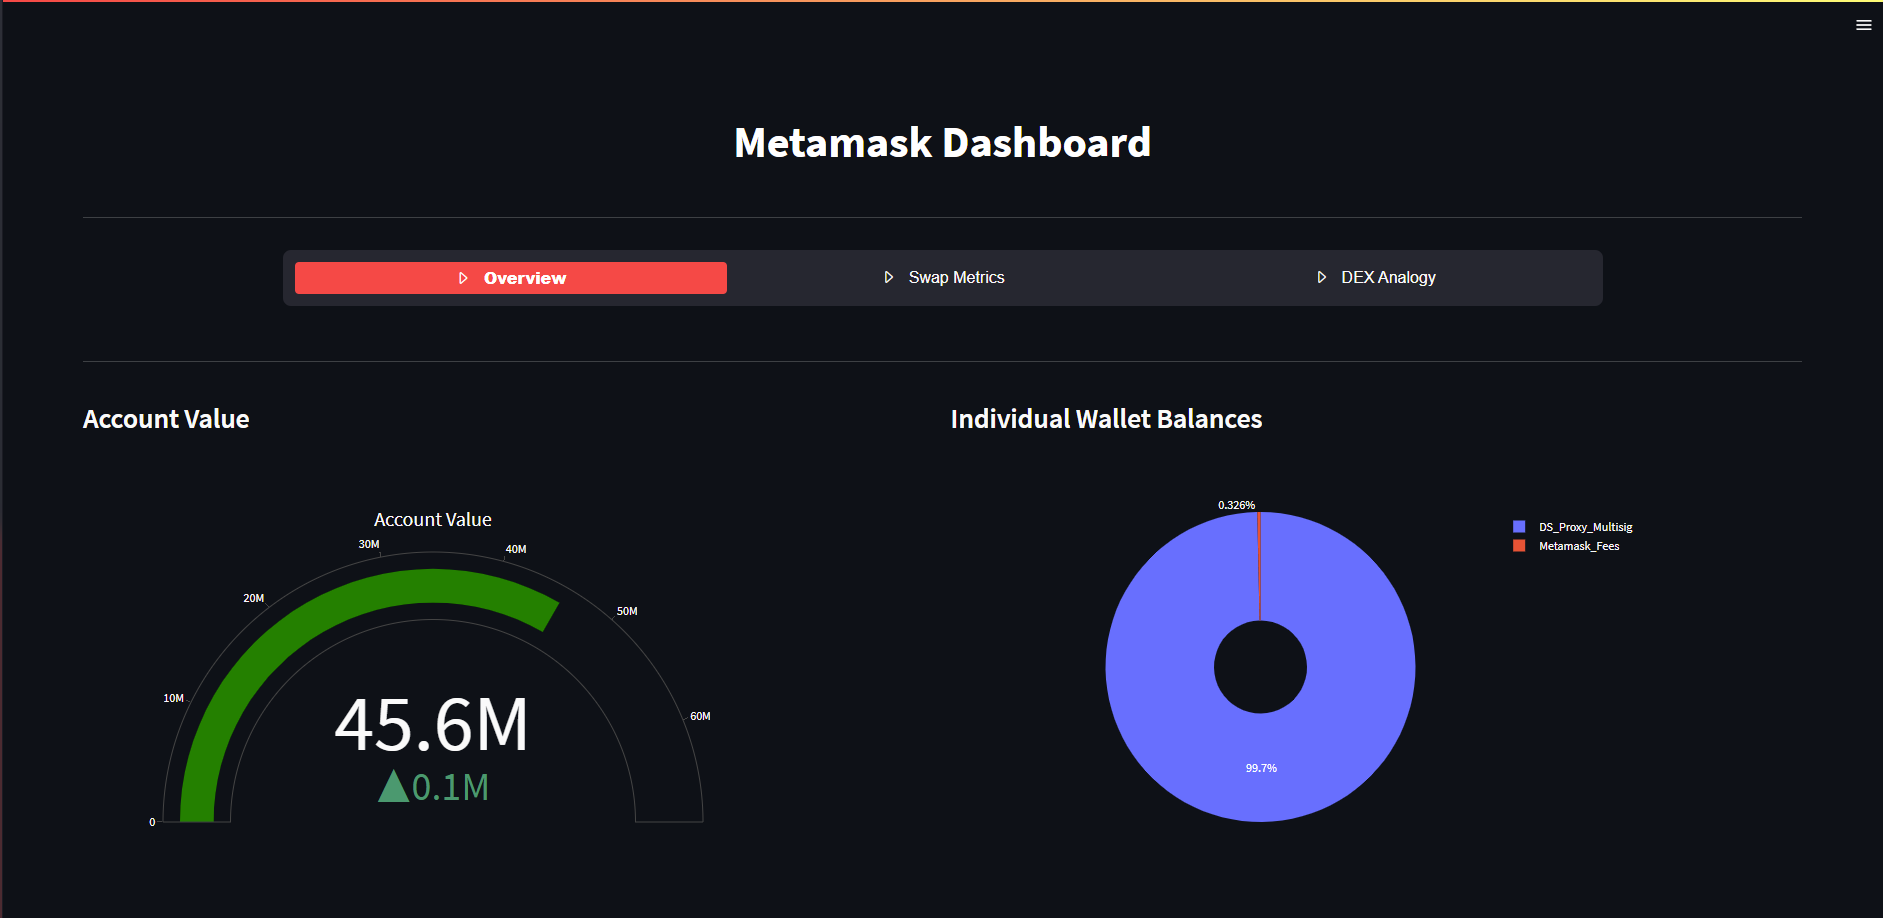

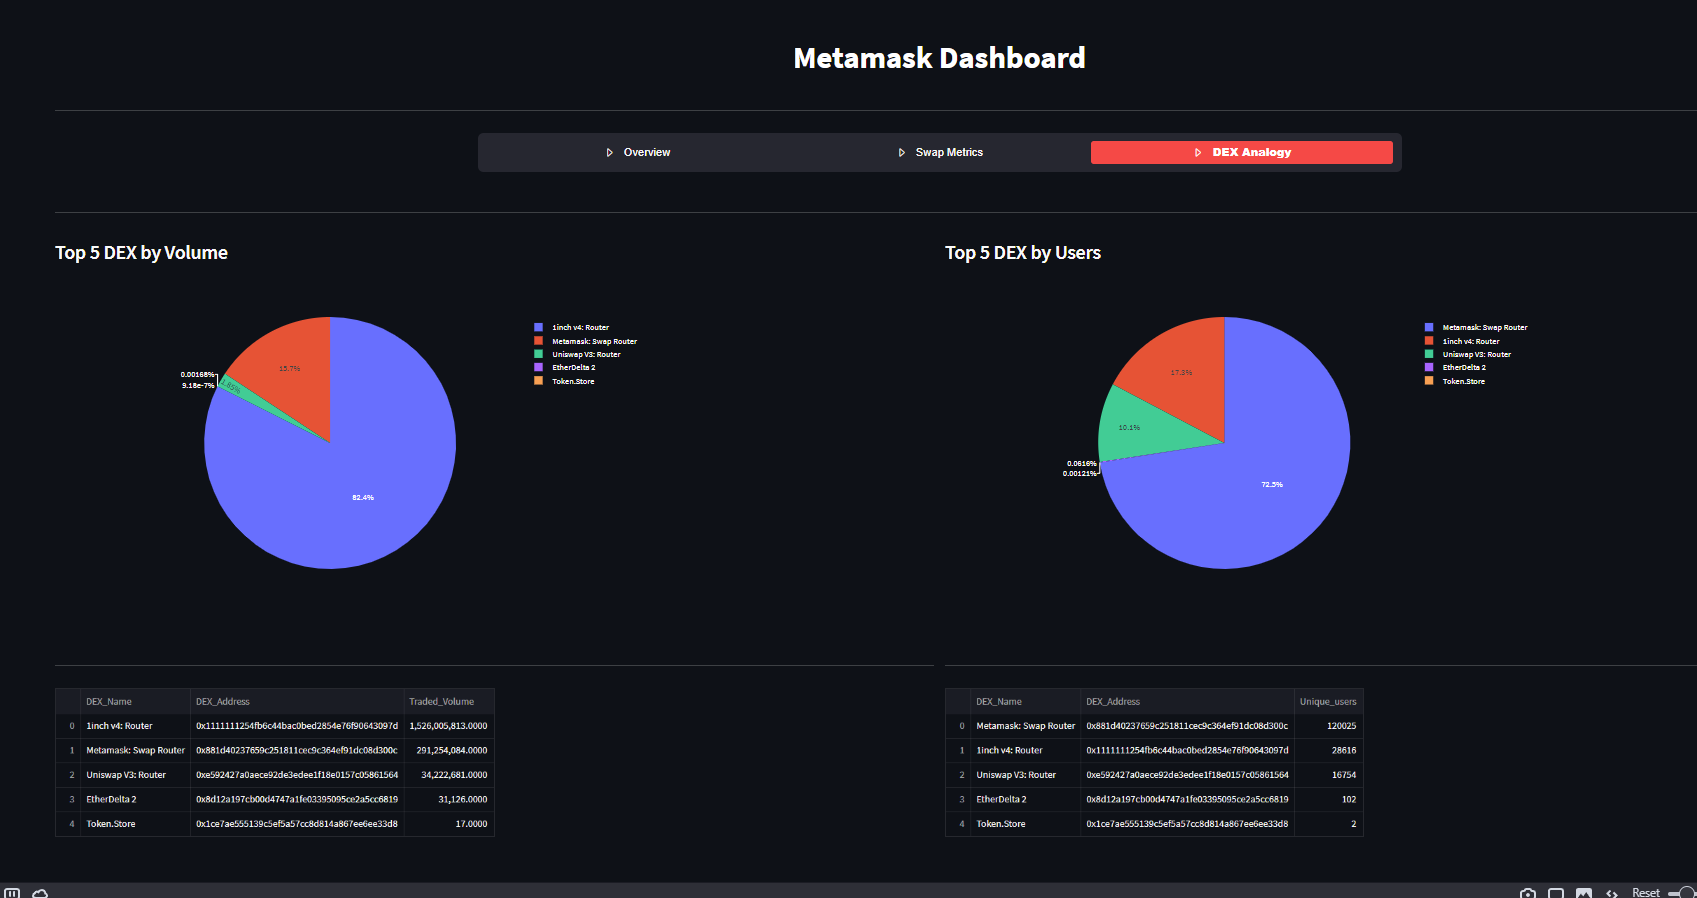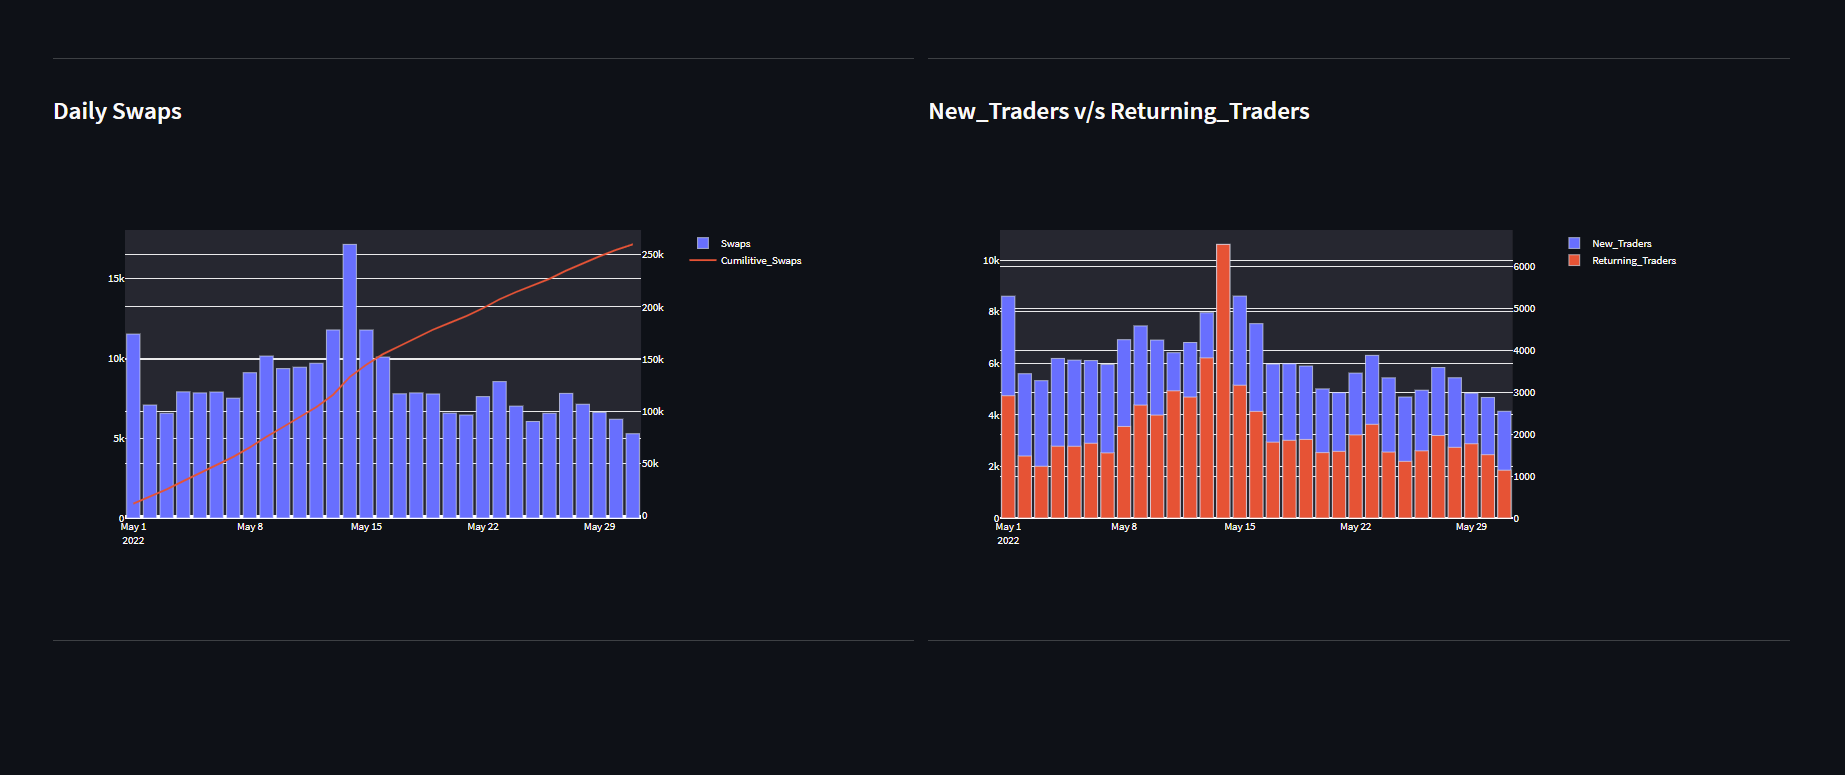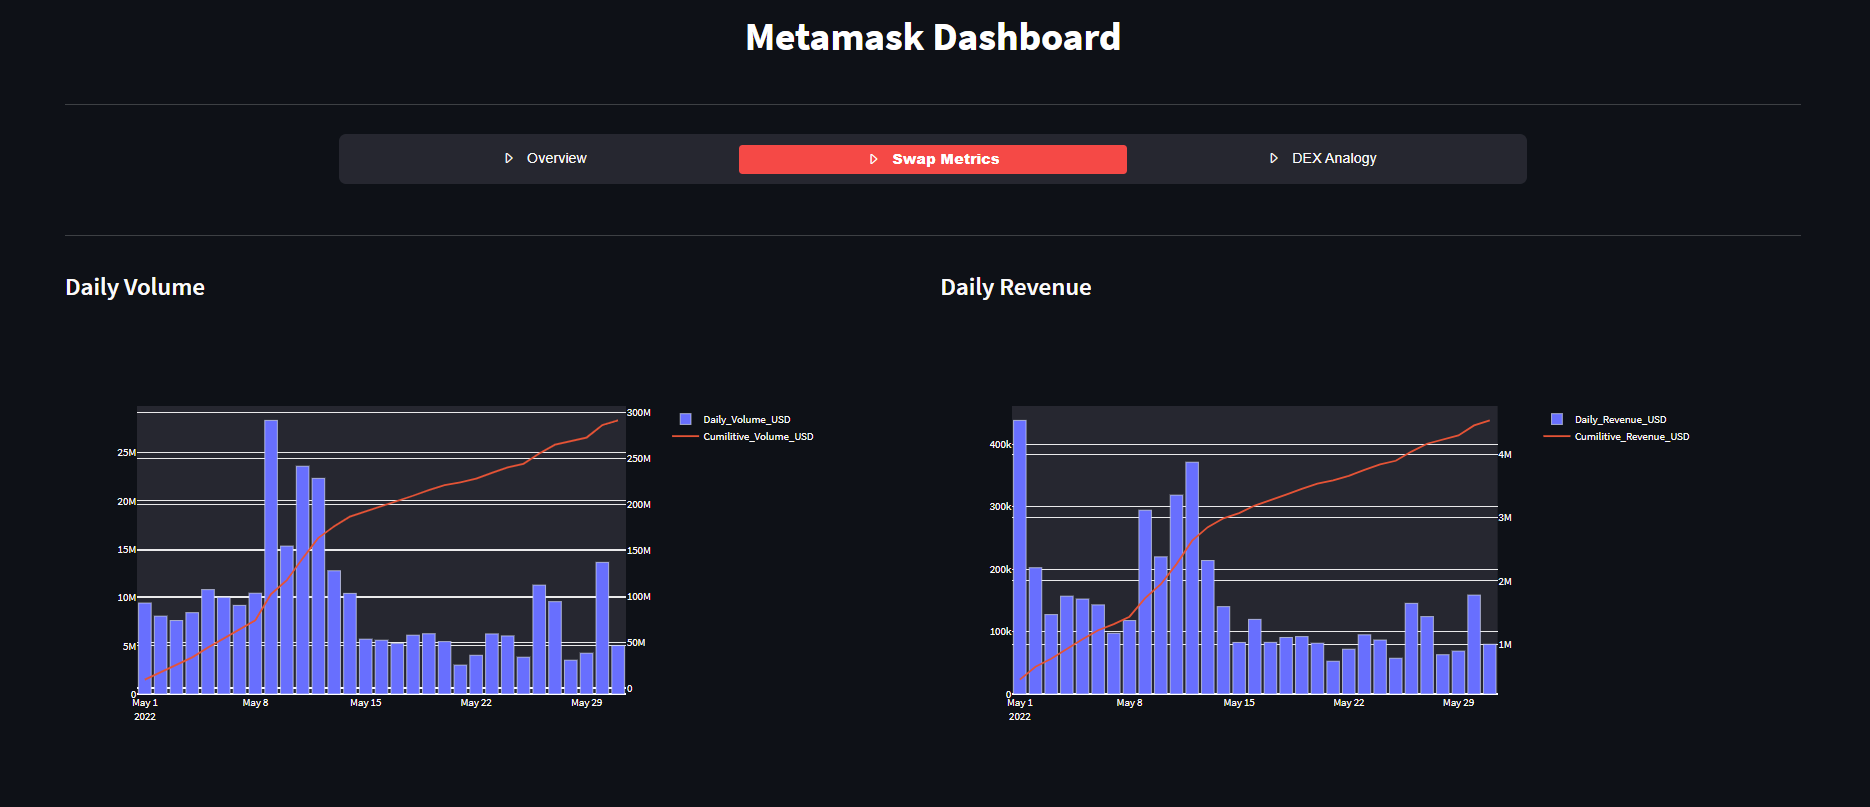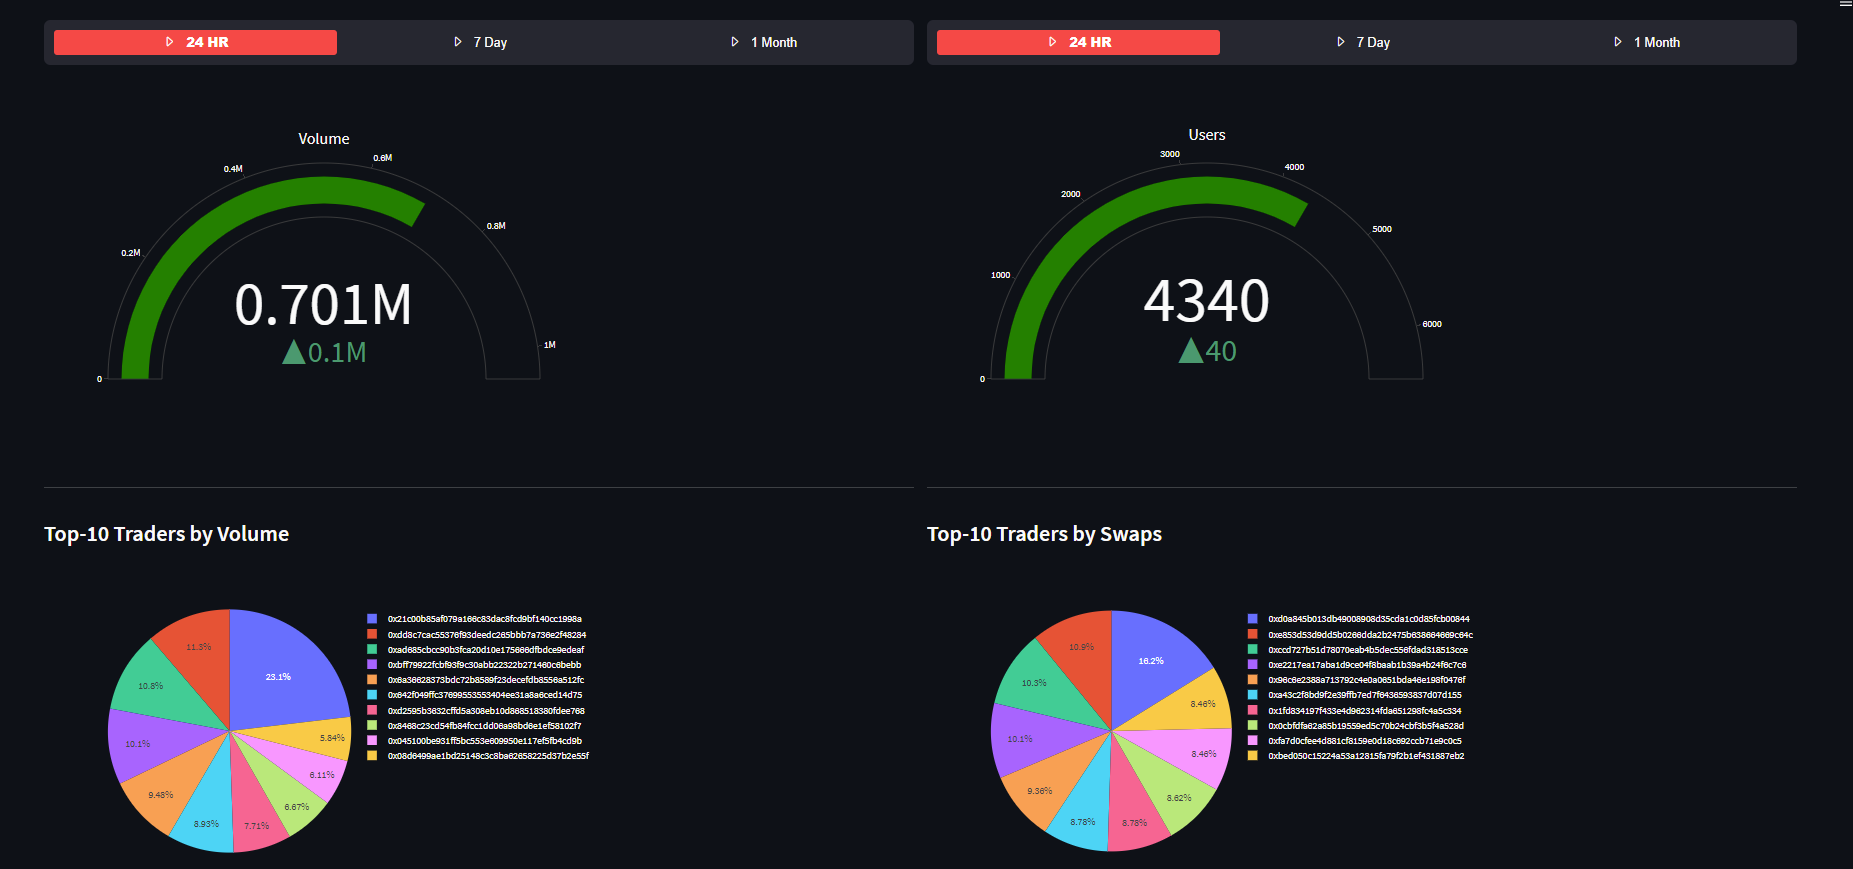



Web App Code Below:

In [ ]:
!pip install streamlit -q
!pip install streamlit-option-menu

In [ ]:
%%writefile Dashboard.py

import streamlit as st
from streamlit_option_menu import option_menu
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


#setting page configuration
st.set_page_config(
    page_title = 'Metamask Dashboard',
    page_icon = '🦊',
    layout = 'wide'
)


#Creating DataFrames from .CSV files (contains Bigquery Resultset)
df_Solo_Wallet_Balances= pd.read_csv("/content/df_Solo_Wallet_Balances.csv")
df_top10_traders_by_Volume= pd.read_csv("/content/df_top10_traders_by_Volume.csv")
df_top10_traders_by_Swaps= pd.read_csv("/content/df_top10_traders_by_Swaps.csv")

df_Daily_Volume= pd.read_csv("/content/df_Daily_Volume.csv")
df_Daily_Revenue= pd.read_csv("/content/ df_Daily_Revenue.csv")
df_Daily_Swaps= pd.read_csv("/content/df_Daily_Swaps.csv")
df_Traders= pd.read_csv("/content/df_Traders.csv")

df_top5_Dex_Volume= pd.read_csv("/content/df_top5_Dex_Volume.csv")
df_top5_Dex_Users= pd.read_csv("/content/df_top5_Dex_Users.csv")

df_Revenue_QOQ= pd.read_csv("/content/df_Revenue_QOQ.csv")
df_Active_Users_QOQ= pd.read_csv("/content/df_Active_Users_QOQ.csv")
df_Volume_QOQ= pd.read_csv("/content/df_Volume_QOQ.csv")
df_Swaps_QOQ= pd.read_csv("/content/df_Swaps_QOQ.csv")


    
#Title and Image
_left, mid, _right = st.columns(3)
with mid:
  st.markdown("<h1 style='text-align: center; color: White;'>Metamask Dashboard</h1>", unsafe_allow_html=True)
   
with _right:   
   st.image("https://nft-insider.nl/wp-content/uploads/2022/02/MetaMask-1068x1061.png",width=125)


st.write("---")
#Main Navigation Bar
select_m = option_menu(
    menu_title = None,
    options = ["Overview", "Swap Metrics", "DEX Analogy","Quarterly Performance"], 
    default_index=0,
    orientation="horizontal",
)
st.write("---")

#Overview
if select_m=="Overview":
  
  col1, col2 = st.columns(2)
  with st.container():
    with col1:
      #col1.metric("Account Value", "45,641,389 USD", "-5 %")
      st.subheader("Account Value")
      figx = go.Figure(go.Indicator(
          domain = {'x': [0, 1], 'y': [0, 1]},
          value = 45641389,
          mode = "gauge+number+delta",
          title = {'text': "Account Value"},
          delta = {'reference': 45541389}))
      st.plotly_chart(figx)
      
      st.write("---")
    with col2:
      st.subheader("Individual Wallet Balances")
      fig1 = px.pie(df_Solo_Wallet_Balances, values='Balance_in_USD', names='Wallet',hole=.3)
      st.plotly_chart(fig1)
      st.write("---")


  with st.container():
    col3, col4 = st.columns(2)
    with col3:
      st.subheader("Volume")
      selected = option_menu(
          menu_title = None,
          options = ["24 HR", "7 Day", "1 Month"], 
          default_index=0,
          orientation="horizontal",
          )
      
      if selected=="24 HR":
        figx = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 700563,
            mode = "gauge+number+delta",
            title = {'text': "Volume"},
            delta = {'reference': 600999}))
        st.plotly_chart(figx)
      
      if selected=="7 Day":
        figy = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 51031218,
            mode = "gauge+number+delta",
            title = {'text': "Volume"},
            delta = {'reference': 65040000}))
        st.plotly_chart(figy)

      if selected=="1 Month":
        figz = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 291254083,
            mode = "gauge+number+delta",
            title = {'text': "Volume"},
            delta = {'reference': 386264083}))
        st.plotly_chart(figz)
      st.write("---")
      st.subheader("Top-10 Traders by Volume")
      figxx = px.pie(df_top10_traders_by_Volume, values='Traded_Volume', names='from_address')
      st.plotly_chart(figxx)
      st.write("---")

  
    with col4:
      st.subheader("Users")
      select = option_menu(
          menu_title = None,
          options = ["24  HR", "7  Day", "1  Month"], 
          default_index=0,
          orientation="horizontal",
          )
      if select=="24  HR":
        figx = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 4344,
            mode = "gauge+number+delta",
            title = {'text': "Users"},
            delta = {'reference': 4300}))
        st.plotly_chart(figx)
      
      if select=="7  Day":
        figy = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 34567,
            mode = "gauge+number+delta",
            title = {'text': "Users"},
            delta = {'reference': 38000}))
        st.plotly_chart(figy)

      if select=="1  Month":
        figz = go.Figure(go.Indicator(
            domain = {'x': [0, 1], 'y': [0, 1]},
            value = 192681,
            mode = "gauge+number+delta",
            title = {'text': "Users"},
            delta = {'reference': 213700}))
        st.plotly_chart(figz)
      st.write("---")
      st.subheader("Top-10 Traders by Swaps")
      figyy = px.pie(df_top10_traders_by_Swaps, values='No_of_Swaps', names='from_address')
      st.plotly_chart(figyy)
      st.write("---")


#Swap Metrics    
if select_m=="Swap Metrics":
  col3, col4 = st.columns(2)
  with st.container():
    with col3:
      st.subheader("Daily Volume")
      trace1 = go.Bar(
          x=df_Daily_Volume['DATE_'],
          y=df_Daily_Volume['Daily_Volume_USD'],
          name='Daily_Volume_USD'
          )
      trace2 = go.Scatter(
          x=df_Daily_Volume['DATE_'],
          y=df_Daily_Volume['Cumilitive_Volume_USD'],
          name='Cumilitive_Volume_USD',
          yaxis='y2'
          )
      fig4 = make_subplots(specs=[[{"secondary_y": True}]])
      fig4.add_trace(trace1)
      fig4.add_trace(trace2,secondary_y=True)
      fig4['layout'].update( width = 850,height = 500,xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
      st.plotly_chart(fig4)
      st.write("---")

  with st.container():
    with col3:
      st.subheader("Daily Swaps")
      trace1 = go.Bar(
          x=df_Daily_Swaps['DATE_'],
          y=df_Daily_Swaps['Swaps'],
          name='Swaps'
          )
      trace2 = go.Scatter(
          x=df_Daily_Swaps['DATE_'],
          y=df_Daily_Swaps['Cumilitive_Swaps'],
          name='Cumilitive_Swaps',
          yaxis='y2'
          )
      fig5 = make_subplots(specs=[[{"secondary_y": True}]])
      fig5.add_trace(trace1)
      fig5.add_trace(trace2,secondary_y=True)
      fig5['layout'].update( width = 850,height = 500,xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
      st.plotly_chart(fig5)
      st.write("---")
      

  with st.container(): 
    with col4:
      st.subheader("Daily Revenue")
      trace1 = go.Bar(
          x=df_Daily_Revenue['DATE_'],
          y=df_Daily_Revenue['Daily_Revenue_USD'],
          name='Daily_Revenue_USD'
          )
      trace2 = go.Scatter(
          x=df_Daily_Revenue['DATE_'],
          y=df_Daily_Revenue['Cumilitive_Revenue_USD'],
          name='Cumilitive_Revenue_USD',
          yaxis='y2'
          )
      fig6 = make_subplots(specs=[[{"secondary_y": True}]])
      fig6.add_trace(trace1)
      fig6.add_trace(trace2,secondary_y=True)
      fig6['layout'].update( width = 850,height = 500,xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
      st.plotly_chart(fig6)
      st.write("---")

  with st.container():   
    with col4:
      st.subheader("New_Traders v/s Returning_Traders")
      trace1 = go.Bar(
          x=df_Traders['DATE_'],
          y=df_Traders['New_Traders'],
          name='New_Traders'
          )
      trace2 = go.Bar(
          x=df_Traders['DATE_'],
          y=df_Traders['Returning_Traders'],
          name='Returning_Traders',
          yaxis='y2'
          )
      fig7 = make_subplots(specs=[[{"secondary_y": True}]])
      fig7.add_trace(trace1)
      fig7.add_trace(trace2,secondary_y=True)
      fig7['layout'].update( width = 850,height = 500,xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
      st.plotly_chart(fig7)
      st.write("---") 

#Dex Analogy
if select_m=="DEX Analogy":
  
  col1, col2 = st.columns(2)
  with st.container():
    with col1:
      st.subheader("Top 5 DEX by Volume")
      fig8 = px.pie(df_top5_Dex_Volume, values='Traded_Volume', names='DEX_Name')
      st.plotly_chart(fig8)
      st.write("---")
      st.write(df_top5_Dex_Volume)
      

  with st.container(): 
    with col2:
      st.subheader("Top 5 DEX by Users")
      fig9 = px.pie(df_top5_Dex_Users, values='Unique_users', names='DEX_Name')
      st.plotly_chart(fig9)
      st.write("---")
      st.write(df_top5_Dex_Users)

#Quarterly Performance
if select_m=="Quarterly Performance":
  col3, col4 = st.columns(2)
  with st.container():
    with col3:
      st.subheader("QOQ Revenue")
      trace1 = go.Bar(
          x=df_Revenue_QOQ['Quarter'],
          y=df_Revenue_QOQ['Revenue_USD'],
          name='Revenue_USD'
          )
      trace2 = go.Line(
          x=df_Revenue_QOQ['Quarter'],
          y=df_Revenue_QOQ['Growth_Rate'],
          name='Growth_Rate',
          yaxis='y2',
          hovertemplate ='%{x}:  %{y}%'
          )
      fig4 = make_subplots(specs=[[{"secondary_y": True}]])
      fig4.add_trace(trace1)
      fig4.add_trace(trace2,secondary_y=True)
      fig4['layout'].update( width = 850,height = 500,xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
      st.plotly_chart(fig4)
      st.write("---")

  with st.container():
    with col3:
      st.subheader("QOQ Active-Users")
      trace1 = go.Bar(
          x=df_Active_Users_QOQ['Quarter'],
          y=df_Active_Users_QOQ['Active_Users'],
          name='Active_Users'
          )
      trace2 = go.Line(
          x=df_Active_Users_QOQ['Quarter'],
          y=df_Active_Users_QOQ['Growth_Rate'],
          name='Growth_Rate',
          yaxis='y2',
          hovertemplate ='%{x}:  %{y}%'
          )
      fig5 = make_subplots(specs=[[{"secondary_y": True}]])
      fig5.add_trace(trace1)
      fig5.add_trace(trace2,secondary_y=True)
      fig5['layout'].update( width = 850,height = 500,xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
      st.plotly_chart(fig5)
      st.write("---")
      

  with st.container(): 
    with col4:
      st.subheader("QOQ Volumes")
      trace1 = go.Bar(
          x=df_Volume_QOQ['Quarter'],
          y=df_Volume_QOQ['Volume_USD'],
          name='Volume_USD'
          )
      trace2 = go.Line(
          x=df_Volume_QOQ['Quarter'],
          y=df_Volume_QOQ['Growth_Rate'],
          name='Growth_Rate',
          yaxis='y2',
          hovertemplate ='%{x}:  %{y}%'
          )
      fig6 = make_subplots(specs=[[{"secondary_y": True}]])
      fig6.add_trace(trace1)
      fig6.add_trace(trace2,secondary_y=True)
      fig6['layout'].update( width = 850,height = 500,xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
      st.plotly_chart(fig6)
      st.write("---")

  with st.container():   
    with col4:
      st.subheader("QOQ Swaps")
      trace1 = go.Bar(
          x=df_Swaps_QOQ['Quarter'],
          y=df_Swaps_QOQ['Swaps'],
          name='Swaps'
          )
      trace2 = go.Line(
          x=df_Swaps_QOQ['Quarter'],
          y=df_Swaps_QOQ['Growth_Rate'],
          name='Growth_Rate',
          yaxis='y2',
          hovertemplate ='%{x}:  %{y}%'
          )
      fig7 = make_subplots(specs=[[{"secondary_y": True}]])
      fig7.add_trace(trace1)
      fig7.add_trace(trace2,secondary_y=True)
      fig7['layout'].update( width = 850,height = 500,xaxis=dict(showgrid=False),yaxis=dict(showgrid=False))
      st.plotly_chart(fig7)
      st.write("---")     
      
    


Writing Dashboard.py


## Running the Web App


1.   Run the Cell Below
2.   Click on the URL
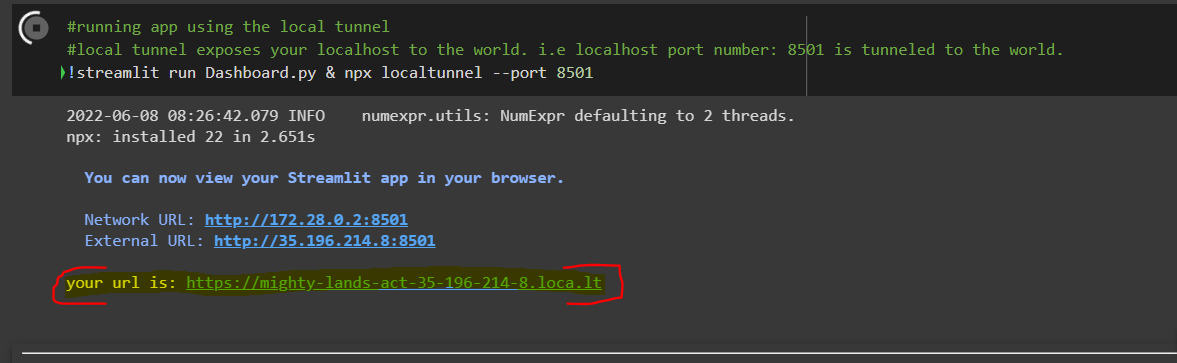
3.   Click on 'Click to Continue'
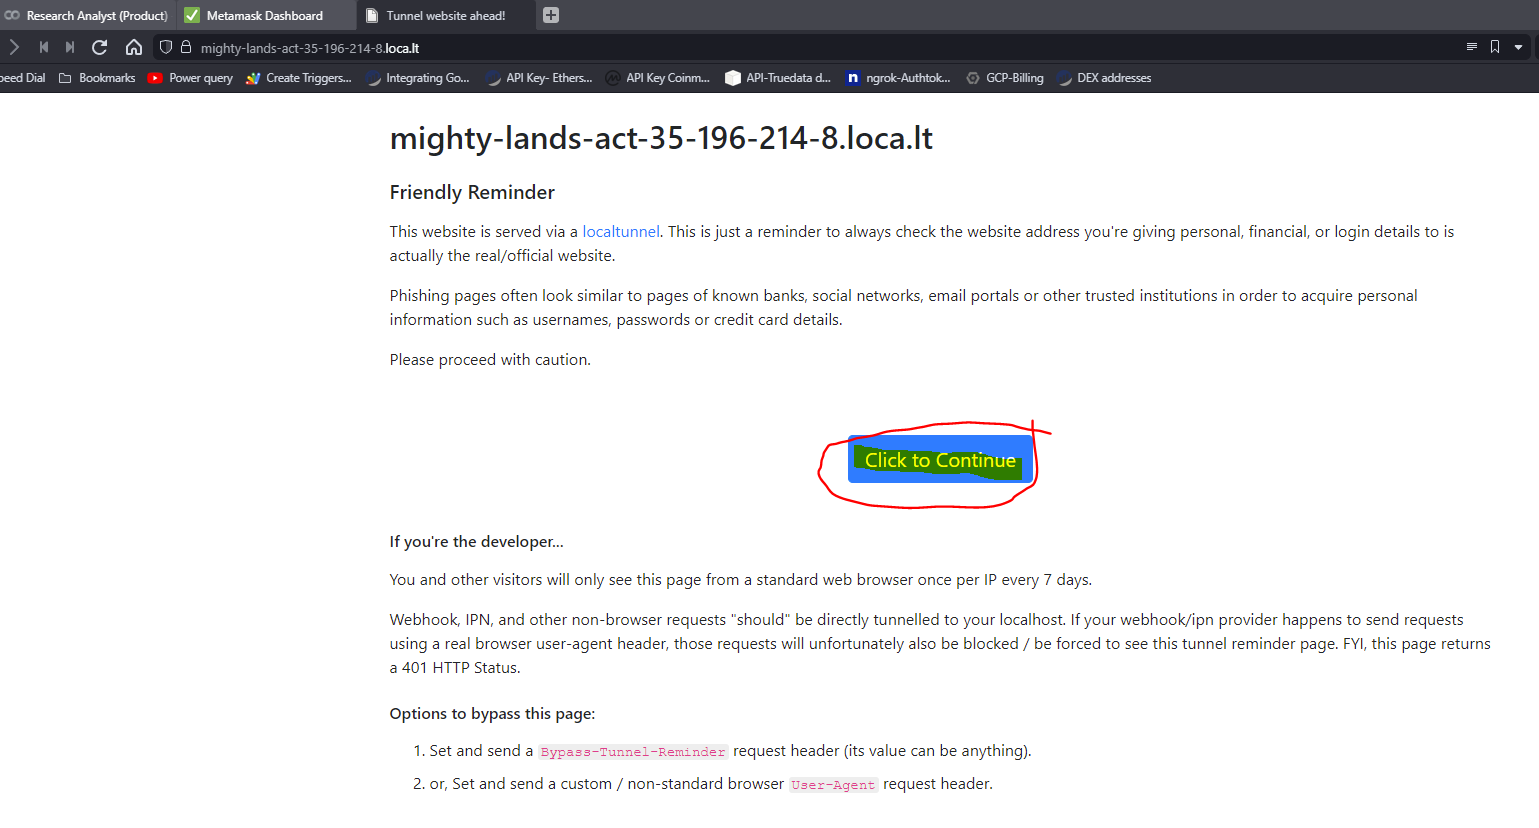
4.   Boom! The Web App is displayed.

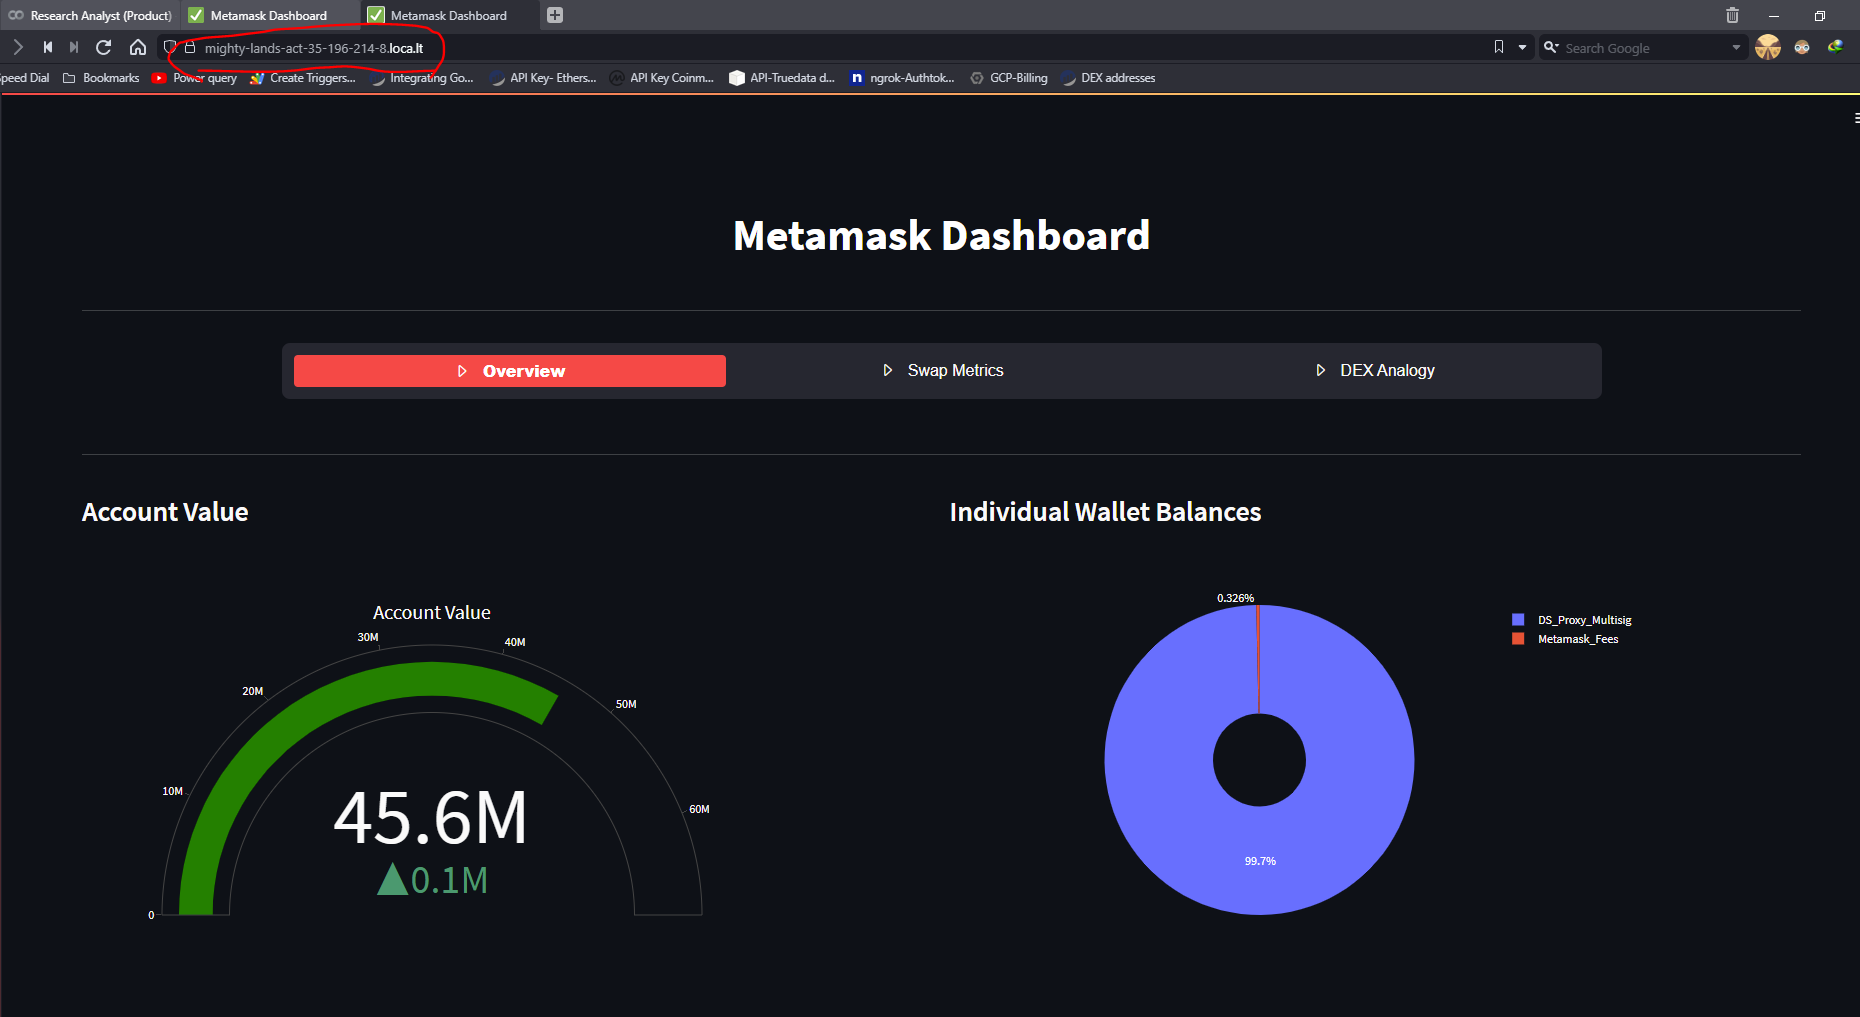





In [ ]:
#running app using the local tunnel 
#local tunnel exposes your localhost to the world. i.e localhost port number: 8501 is tunneled to the world.
!streamlit run Dashboard.py & npx localtunnel --port 8501

2022-07-02 05:30:06.155 INFO    numexpr.utils: NumExpr defaulting to 2 threads.

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.82.118.57:8501

npx: installed 22 in 4.296s
your url is: https://curvy-cooks-leave-34-82-118-57.loca.lt
/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.


  Stopping...
^C
